# 1. Data Preparation

## 1.1 Load relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## 1.2 Read CSV and inspect features

In [2]:
df = pd.read_csv('data/raw/Student_performance_data _.csv')
print(df.columns.to_list())

['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA', 'GradeClass']


# 2. Data wrangling

## 2.1 Check for possible outliers

In [3]:
df.describe()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,690.655244,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,1001.000000,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1598.750000,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,2196.500000,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,2794.250000,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,3392.000000,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


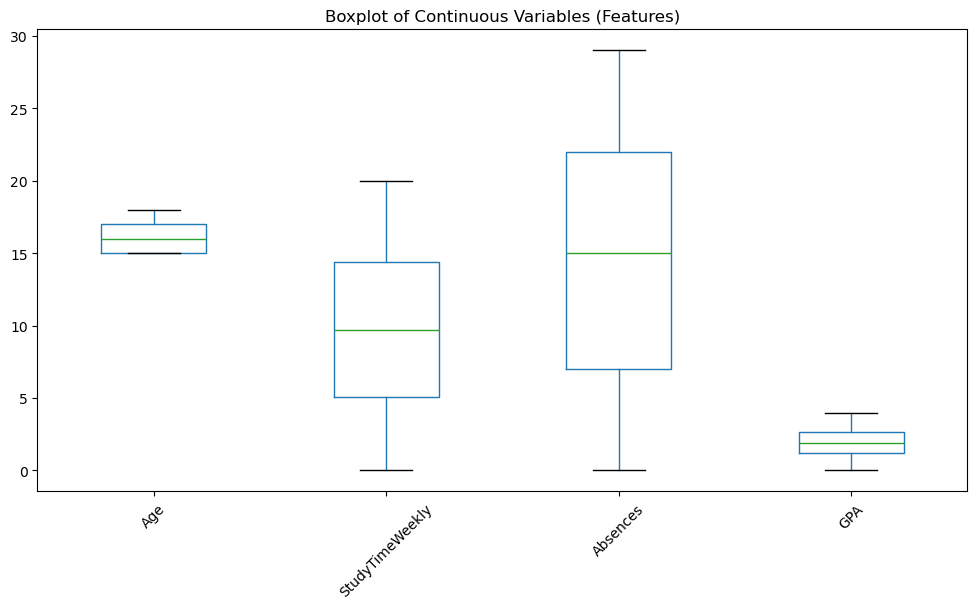

In [4]:
features = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']

df[features].boxplot(figsize=(12,6), grid=False)
plt.title('Boxplot of Continuous Variables (Features)')
plt.xticks(rotation=45)  # Rotate x labels for readability
plt.show()

Only 'Age', 'StudyTimeWeekly', 'Absences' and 'GPA' require outlier detections as they are continuous variables. The rest of the variables/features are categorical and thus, do not have to be checked for outliers. 

The maximum and minimum values of the continuous variables are observed to be within reasonable ranges (between lower fence and upper fence). This is also evident by the lack of dots that represent outliers in boxplots. Hence, it can be concluded that the dataset does not include outliers.

## 2.2 Missing values

In [5]:
df.isnull().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

No missing values are included.

## 2.3 Decide between GPA and GradeClass for Risk Level conversion

In [6]:
# Convert GPA to GradeClass to check for inconsistencies
def expected_grade(gpa):
    if gpa >= 3.5:
        return "A"
    elif 3.00 <= gpa < 3.5:
        return "B"
    elif 2.5 <= gpa < 3.0:
        return "C"
    elif 2.0 <= gpa < 2.5:
        return "D"
    elif gpa < 2.0:
        return "F"

In [7]:
df['ExpectedGradeClass'] = df['GPA'].apply(expected_grade)

print("Number of inconsistent data:")
print(len(df[df['GradeClass'] != df['ExpectedGradeClass']]))

Number of inconsistent data:
2392


This indicates that 2392 students' grade classes have been miscalculated and thus, it is best to use GPA to categorise risk level.

## 2.4 Feature selection

In [8]:
df = df.drop(['Gender', 'StudentID', 'GradeClass', 'Ethnicity', 'ExpectedGradeClass'], axis=1)

Gender: does not contribute significantly to student's academic outcome (may cause bias)

StudentID: dropped because it is for identification and does not provide valuable information

GradeClass: dropped because of inconsistency with GPA 

Ethnicity: does not directly impact student's academic outcome

ExpectedGradeClass: overlaps with GPA

## 2.5 Convert GPA to Risk Levels as target variable

In [9]:
# Translate GPA to risk levels
def to_risk(gpa):
    if gpa >= 3.0:
        return '0'

    elif 2.5 <= gpa < 3.0:
        return '1'

    elif 2.0 <= gpa < 2.5:
        return '2'

    elif gpa < 2.5:
        return '3'

In [10]:
df['RiskLevel'] = df['GPA'].apply(to_risk)

In [11]:
df.head(5)

,Age,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,RiskLevel
0,17,2,19.833723,7,1,2,0,0,1,0,2.929196,1
1,18,1,15.408756,0,0,1,0,0,0,0,3.042915,0
2,15,3,4.210570,26,0,2,0,0,0,0,0.112602,3
3,17,3,10.028829,14,0,3,1,0,0,0,2.054218,2
4,17,2,4.672495,17,1,3,0,0,0,0,1.288061,3


# 2. Data Visualisation

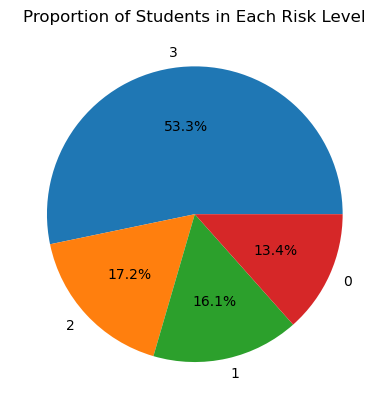

In [12]:
counts = df['RiskLevel'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Proportion of Students in Each Risk Level')
plt.show()

Students at Risk Level 3 (Very High) covers over 50% of the total, indicating class imbalance. This means we have to make sure classes are treated equally in model training later to .

# 3. Model Training

## 3.1 Create train and test sets

In [13]:
X = df[['Age', 'StudyTimeWeekly', 'Absences', 'ParentalSupport', 'ParentalEducation', 
        'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']]

y = df['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
# Scale features to ensure same scale (reduced bias)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

## 3.2 Random Forest Classifier

In [15]:
# Hyperparameter tuning
clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=2,
    random_state=42,
    max_features='sqrt',
    criterion = 'gini',
    class_weight = 'balanced'
)

clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=8,
                       n_estimators=1000, random_state=42)

In [16]:
y_pred_clf = clf.predict(X_test_scaled)

In [17]:
# Generate classification report
print('\n------------------------Random Forest------------------------')
print(classification_report(y_test, y_pred_clf, zero_division=0))


------------------------Random Forest------------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        65
           1       0.60      0.61      0.61        80
           2       0.59      0.67      0.63        85
           3       0.94      0.90      0.92       249

    accuracy                           0.79       479
   macro avg       0.72      0.73      0.73       479
weighted avg       0.80      0.79      0.79       479



## 3.3 SVM

In [18]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', random_state=42)

svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [19]:
y_pred_svm = svm_model.predict(X_test_scaled)

print('--------------------------- SVM ----------------------------')
print(classification_report(y_test, y_pred_svm, zero_division=0))

--------------------------- SVM ----------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        65
           1       0.62      0.62      0.62        80
           2       0.56      0.54      0.55        85
           3       0.90      0.94      0.92       249

    accuracy                           0.78       479
   macro avg       0.73      0.71      0.71       479
weighted avg       0.78      0.78      0.78       479



## 3.4 Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight = 'balanced'
)
reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [21]:
y_pred_reg = reg.predict(X_test_scaled)

print('--------------------------- Logistic Regression ----------------------------')
print(classification_report(y_test, y_pred_reg, zero_division=0))

--------------------------- Logistic Regression ----------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        65
           1       0.71      0.70      0.70        80
           2       0.62      0.75      0.68        85
           3       0.97      0.89      0.92       249

    accuracy                           0.83       479
   macro avg       0.78      0.80      0.78       479
weighted avg       0.84      0.83      0.83       479



## 3.5 Best Model Evaluation

Out of the three models, logistic regression performed best. It achieved an overall accuracy of 0.83, outperforming Random Forest Classifier (0.79) and SVM (0.78). Most importantly, it produced the highest recall for students at Risk Levels 2 (High) and 3 (Very High), which is the most critical metric for early-risk intervention. Prioritising recall ensures that the maximum number of at-risk students (True Positives) are correctly identified for timely support. Furthermore, it also achieved the highest weighted average for precision (0.84) and f1-score (0.83), making it the best suited model for risk level predictions.

In [26]:
# Confusion matrix
confusion_matrix(y_test, y_pred_reg)

array([[ 55,  10,   0,   0],
       [ 13,  56,  11,   0],
       [  0,  13,  64,   8],
       [  0,   0,  28, 221]])

The confusion matrix depicts that the model often confuses between adjacent classes. For instance, the model misclassified 13 risk level 2 students as risk level 1. However, no very high-risk studetns are misclassified as low or medium risk and the majority are correctly identified. This ensures students at very high risk to receive proactive academic support. 

# 4 Export

## 4.1 Model and Scaler to use in Streamlit

In [23]:
joblib.dump(reg, 'student_risk_model.pkl')

['student_risk_model.pkl']

In [24]:
# Export scaler to scale user input features
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## 4.2 Export cleaned data 

In [25]:
df.to_csv("data/cleaned/student_performance_data_cleaned.csv", index=False)